In [1]:
import os
from pathlib import Path
if '_cwd' not in locals():
    _cwd = os.getcwd()
    os.chdir(Path(_cwd)/'..')
    os.chdir(Path(os.getcwd())/'..') # ew

from explain.gradcam_heatmap_trajectories import compute_gradcam_and_pca, plot_heatmaps_per_label_and_component,plot_all_trajectories_with_and_without_heatmaps, compute_binned_heatmaps_per_label_and_component
from deep_traffic_generation.core.datasets import TrafficDataset
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from explain.gradcam_heatmap_trajectories import compute_projected_gradcam_activations, compute_gradcam_per_sample, load_data_and_model,perform_pca_on_latent_vectors


# enable autoreload     
%load_ext autoreload    
%autoreload 2

# Seed random generators for reproducibility
import numpy as np
import torch
import random
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
# preparing the data
dataset_name = "zurich_2019"
dataset = TrafficDataset.from_file(
        f"data/aircraft/{dataset_name}.parquet",
        features=["longitude", "latitude"],
        scaler=MinMaxScaler(feature_range=(-1, 1)),
        shape= "sequence",
        info_params={"features": ["latitude", "longitude"], "index": -1},
    )

In [3]:
dataset_name = "zurich_2019_flyover"
dataset_flyover = TrafficDataset.from_file(
        f"data/aircraft_flyover/{dataset_name}.parquet",
        features=["longitude", "latitude"],
        scaler=MinMaxScaler(feature_range=(-1, 1)),
        shape= "sequence",
        info_params={"features": ["latitude", "longitude"], "index": -1},
    )

In [4]:
def get_positions_and_labels(dataset):
    positions = []
    labels = dataset.labels

    for flight, infos in dataset:
        positions.append(flight)

    positions = np.array(positions)
    labels = np.array(labels)

    return positions, labels

positions, labels = get_positions_and_labels(dataset)
positions_flyover, labels_flyover = get_positions_and_labels(dataset_flyover)

# save the data to a file
np.save("data/aircraft_flyover/positions.npy", positions)
np.save("data/aircraft_flyover/labels.npy", labels)
np.save("data/aircraft_flyover/positions_flyover.npy", positions_flyover)
np.save("data/aircraft_flyover/labels_flyover.npy", labels_flyover)

In [8]:
# Define your parameters here
positions_path = 'data/aircraft_flyover/positions.npy'
labels_path = 'data/aircraft_flyover/labels.npy'
positions_flyover_path = 'data/aircraft_flyover/positions_flyover.npy'
labels_flyover_path = 'data/aircraft_flyover/labels_flyover.npy'

target_layer = 'encoder.0.layers.6'
device = 'cuda'  # or 'cuda' if you have a GPU

# Load the data and the model
model_path = r'models\aircraft-flyover.ckpt'

In [9]:
dataset, labels, unique_labels, model, gcam = load_data_and_model(
        positions_flyover_path, labels_flyover_path, model_path, target_layer, device
    )

gradcam_activations, sample_labels, mu_list, positions_array = compute_gradcam_per_sample(
        dataset, labels, model, gcam, device
    )

Positions shape: (1183, 2, 200)
Labels shape: (1183,)
Unique labels: ['East' 'Flyover' 'South' 'West']
Computing Grad-CAM activations for all samples...


Grad-CAM Computation:  28%|██▊       | 332/1183 [01:25<03:40,  3.87it/s]


KeyboardInterrupt: 

In [ ]:
# Select only mu values for the labels not equal 5 (flyover label)
mu_list_filtered = mu_list[sample_labels != 5]
# print both lenghts
print(len(mu_list), len(mu_list_filtered))

1183 1183


In [ ]:
# save mu_list_filtered to a file
np.save("data/mu_list_filtered.npy", mu_list_filtered)

In [ ]:
pca, scores = perform_pca_on_latent_vectors(mu_list_filtered, n_components=8)

Performing PCA on latent vectors with 8 components...
Explained variance ratios: [0.59182674 0.20476153 0.06447925 0.04155705 0.02829669 0.0186204
 0.01237184 0.00934517]
Explained variance: [27.717226    9.589667    3.019779    1.9462558   1.3252288   0.87205577
  0.57941455  0.4376654 ]
Components shape: (8, 64)


In [ ]:
gradcam_projections = compute_projected_gradcam_activations(gradcam_activations, pca)

Grad-CAM activations shape before projection: (1183, 200, 64)
Grad-CAM projections shape: (1183, 200, 8)


In [ ]:
fix = 10
plt.rcParams.update({
    "text.usetex": False,          # Disable LaTeX rendering
    "font.family": "serif",        # Use serif fonts
    "font.size": 16,               # Base font size
    "axes.titlesize": 12+fix,          # Titles slightly larger
    "axes.labelsize": 11+fix,          # Axis labels size
    "xtick.labelsize": 11+fix,         # Tick labels size
    "ytick.labelsize": 11+fix,
    "legend.fontsize": 11,
})

(heatmaps_dict,
 (global_x_min, global_x_max),
 (global_y_min, global_y_max),
 global_min, global_max) = compute_binned_heatmaps_per_label_and_component(
     positions_flyover,
     gradcam_projections,
     sample_labels,
     unique_labels,
     n_components=1,
     grid_size=200,
     bin_stats='mean',
     sigma=5,
     norm = True
)

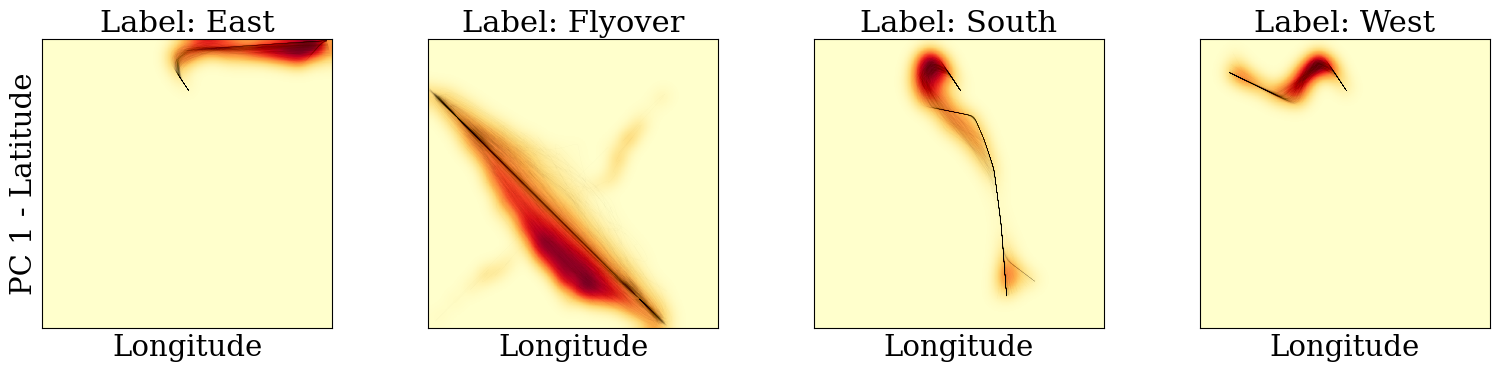

In [ ]:
fix = 10
plt.rcParams.update({
    "text.usetex": False,          # Disable LaTeX rendering
    "font.family": "serif",        # Use serif fonts
    "font.size": 16,               # Base font size
    "axes.titlesize": 12+fix,          # Titles slightly larger
    "axes.labelsize": 11+fix,          # Axis labels size
    "xtick.labelsize": 11+fix,         # Tick labels size
    "ytick.labelsize": 11+fix,
    "legend.fontsize": 11,
})

plot_heatmaps_per_label_and_component(
    heatmaps_dict,
    positions_flyover,
    sample_labels,
    unique_labels,
    n_components=1,
    x_range=(global_x_min, global_x_max),
    y_range=(global_y_min, global_y_max),
    global_min=global_min,
    global_max=global_max,
    invert_y_axis=False,
    comp_norm=False
)


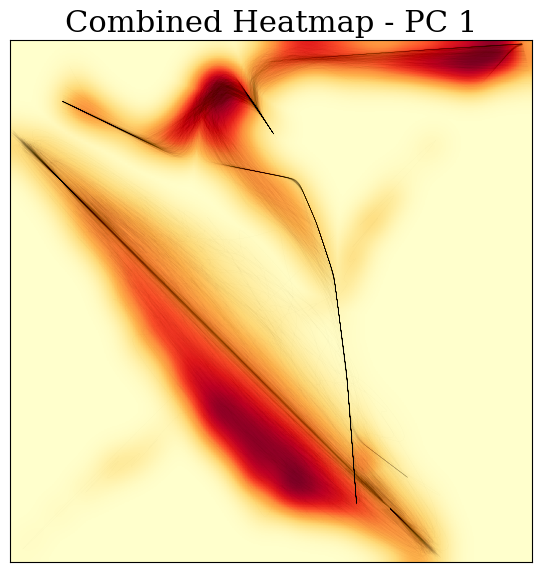

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fix = 10
plt.rcParams.update({
    "text.usetex": False,          # Disable LaTeX rendering
    "font.family": "serif",        # Use serif fonts
    "font.size": 16,               # Base font size
    "axes.titlesize": 12+fix,          # Titles slightly larger
    "axes.labelsize": 11+fix,          # Axis labels size
    "xtick.labelsize": 11+fix,         # Tick labels size
    "ytick.labelsize": 11+fix,
    "legend.fontsize": 11,
})

plot_all_trajectories_with_and_without_heatmaps(
    heatmaps_dict,
    positions_flyover,
    sample_labels,
    unique_labels,
    n_components=1,
    x_range=(global_x_min, global_x_max),
    y_range=(global_y_min, global_y_max),
    global_min=global_min,
    global_max=global_max,
    invert_y_axis=False,
    show_trajectories=False,
    concat_fun=np.maximum,
    save_path="figures/flyover/trained/heatmaps.pdf"
)
